In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylops
from scipy.signal import butter, filtfilt
import wavelets
import warnings
import scienceplots

warnings.filterwarnings("ignore")

plt.style.use(["bmh", "science", "notebook", "grid"])
# Shades of blue
PRIMARY = "#0072b2"
PRIMARY_DARK = "#000080"
# Shades of red
SECONDARY = "#a60628"
SECONDARY_DARK = "#79011B"
# Shades of green
TERCIARY = "#228b22"
TERCIARY_DARK = "#556b2f"
# Shades of yellow
ALTERNATIVE = "#edb230"
ALTERNATIVE_DARK = "#e77728"
# Shades of black
TEXT_COLOR = "#212121"
plt.rc("font", family="Verdana")
FONT_SIZE = 16
LABEL_SIZE = 12
PARAM_SIZE = 14
VMIN = 5000
VMAX = 19000

In [3]:
data_amp = np.load("Uncompressed/amplitude.npy")
data_imp = np.load("Uncompressed/impedance.npy")

print(f" data shape {np.shape(data_amp)}")
print(f" data shape {np.shape(data_imp)}")

 data shape (256, 256, 256)
 data shape (256, 256, 256)


In [4]:
"""
Fazendo a freq de baixa. Aqui, não é necessário passar por todo o processo de amarração de poço, visto que é um dados sintético. Nesse caso, é apenas passado um filtro passa-baixa para simular os dados de baixa frequência. Tanto na que vai ser usada para a inversão, tanto na original para comparar posteriormente.
"""

cutoff_back = 6  # cutoff frequency
cutoff_30hz = 30  # cutoff frequency
fs = 128  # Frequency sample


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


imp_30hz = butter_lowpass_filtfilt(data_imp, cutoff_30hz, fs, order=5)
imp_background = butter_lowpass_filtfilt(data_imp, cutoff_back, fs, order=5)

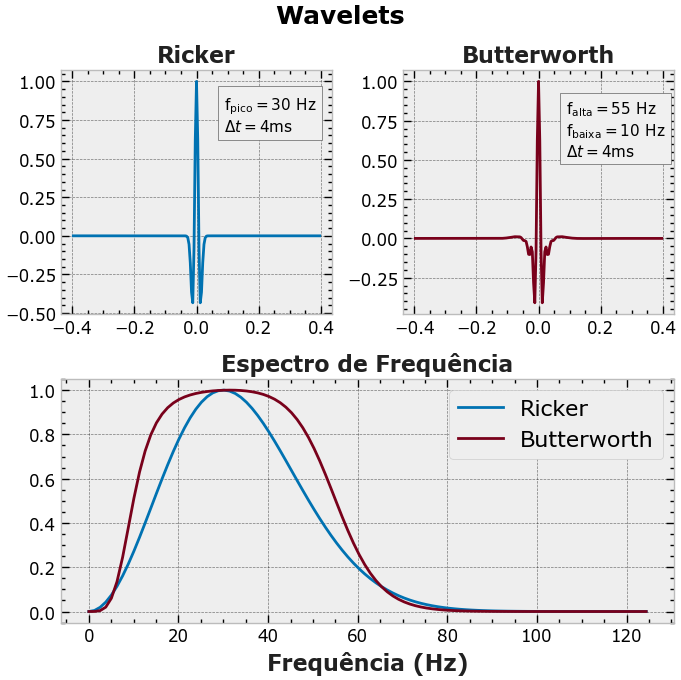

In [5]:
SAMPLE = 100
DT = 4

# Ricker
PKFQ = 30
twlet, wlet, freqs, fft = wavelets.ricker(peak_freq=PKFQ, samples=SAMPLE, dt=DT)

# Butter
FREQHI = 55
FREQLOW = 10
DTB = 4
twlet_b, wlet_b, freqs_b, fft_b = wavelets.butter(
    freq_hi=FREQHI, freq_low=FREQLOW, samples=SAMPLE, dt=DTB
)

plt.figure(figsize=(7, 7))

textstr1 = "\n".join(
    (r"$\text{f}_{\text{pico}}=%d$ Hz" % (PKFQ), r"$\Delta t=%d$ms" % (DT))
)

textstr2 = "\n".join(
    (
        r"$\text{f}_{\text{alta}}=%d$ Hz" % (FREQHI),
        r"$\text{f}_{\text{baixa}}=%d$ Hz" % (FREQLOW),
        r"$\Delta t=%d$ms" % (DTB),
    )
)

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet, color=PRIMARY)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.title("Ricker", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.75,
    textstr1,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b, color=SECONDARY_DARK)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.title("Butterworth", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold")
plt.text(
    0.60,
    0.65,
    textstr2,
    fontsize=11,
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="#f0f0f0", edgecolor="#616161"),
)

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both", labelsize=LABEL_SIZE)
plt.plot(freqs, fft, color=PRIMARY, label="Ricker")
plt.title(
    "Espectro de Frequência", fontsize=FONT_SIZE, color=TEXT_COLOR, fontweight="bold"
)
plt.plot(freqs_b, fft_b, color=SECONDARY_DARK, label="Butterworth")
plt.xlabel("Frequência (Hz)", color=TEXT_COLOR, fontweight="bold")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig("Figures/grid_wavelets.png", dpi=500, bbox_inches="tight")
plt.show()

In [6]:
import numpy as np
import pylops
from tqdm import tqdm

# Supondo que data_amp, imp_background, wlet e wlet_b sejam arrays 3D com dimensões (ix, iy, iz)
ix, iy, iz = data_amp.shape

# Inicializar arrays para armazenar os resultados da inversão
max_likelihood_inv_ricker = np.zeros((ix, iy, iz))
max_likelihood_inv_butter = np.zeros((ix, iy, iz))
sparse_spike_inv_ricker = np.zeros((ix, iy, iz))
sparse_spike_inv_butter = np.zeros((ix, iy, iz))
sparse_spike_inv_est = np.zeros((ix, iy, iz))
EPSI = 0.1
EPSR = 0.05
# Iterar sobre as dimensões ix e iy
for i in tqdm(range(ix), desc="Processing inversion"):
    max_likelihood_inv_ricker[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet / 2,
        m0=imp_background[i, :, :],
        explicit=True,
        epsI=0.6,
        epsR=None,
        simultaneous=False,
        #**dict(iter_lim=1000, damp=0.45)
    )[0]
    
    max_likelihood_inv_butter[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet_b / 2,
        m0=imp_background[i, :, :],
        explicit=True,
        epsI=0.6,
        epsR=None,
        simultaneous=False,
        #**dict(iter_lim=1000, damp=0.45)
    )[0]
    
    sparse_spike_inv_ricker[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet / 2,
        m0=imp_background[i, :, :],
        explicit=False,
        epsI=EPSI,
        epsR=EPSR,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=1000, damp=0.45)
    )[0]

    sparse_spike_inv_butter[i, :, :] = pylops.avo.poststack.PoststackInversion(
        data_amp[i, :, :],
        wlet_b / 2,
        m0=imp_background[i, :, :],
        explicit=False,
        epsI=EPSI,
        epsR=EPSR,
        #epsRL1=0.02,
        simultaneous=False,
        **dict(iter_lim=1000, damp=0.45)
    )[0]

# Agora sparse_spike_inv_ricker e sparse_spike_inv_butter contêm os resultados da inversão para o cubo inteiro
from scipy import stats
from scipy.stats import pearsonr as pearson

ss_correlation_ricker = pearson(
    imp_30hz.flatten(), sparse_spike_inv_ricker.flatten()
)[0]
ss_correlation_butter = pearson(
    imp_30hz.flatten(), sparse_spike_inv_butter.flatten()
)[0]
ml_correlation_ricker = pearson(
    imp_30hz.flatten(), max_likelihood_inv_ricker.flatten()
)[0]
ml_correlation_butter = pearson(
    imp_30hz.flatten(), max_likelihood_inv_butter.flatten()
)[0]

print(f"Pearson Global de Ricker - SS é: {ss_correlation_ricker:.2f}")
print(f"Pearson Global de Butter - SS é: {ss_correlation_butter:.2f}")
print(f"Pearson Global de Ricker - ML é: {ml_correlation_ricker:.2f}")
print(f"Pearson Global de Butter - ML é: {ml_correlation_butter:.2f}")

Processing inversion: 100%|██████████| 256/256 [01:17<00:00,  3.29it/s]


Pearson Global de Ricker - SS é: 0.75
Pearson Global de Butter - SS é: 0.72
Pearson Global de Ricker - ML é: 0.83
Pearson Global de Butter - ML é: 0.82


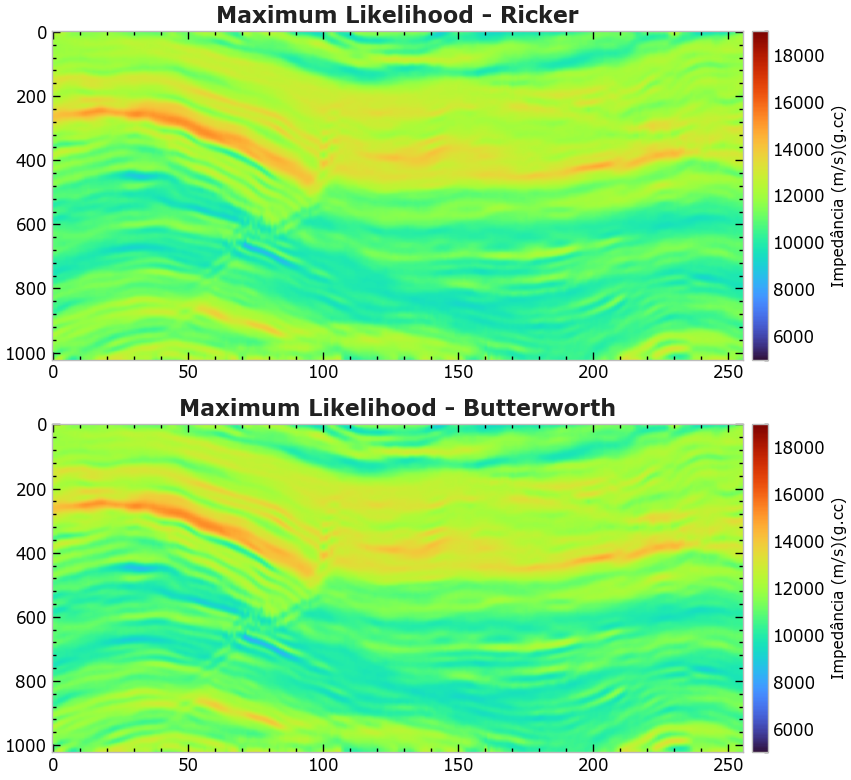

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    max_likelihood_inv_ricker[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "Maximum Likelihood - Ricker",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    max_likelihood_inv_butter[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "Maximum Likelihood - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ml_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()

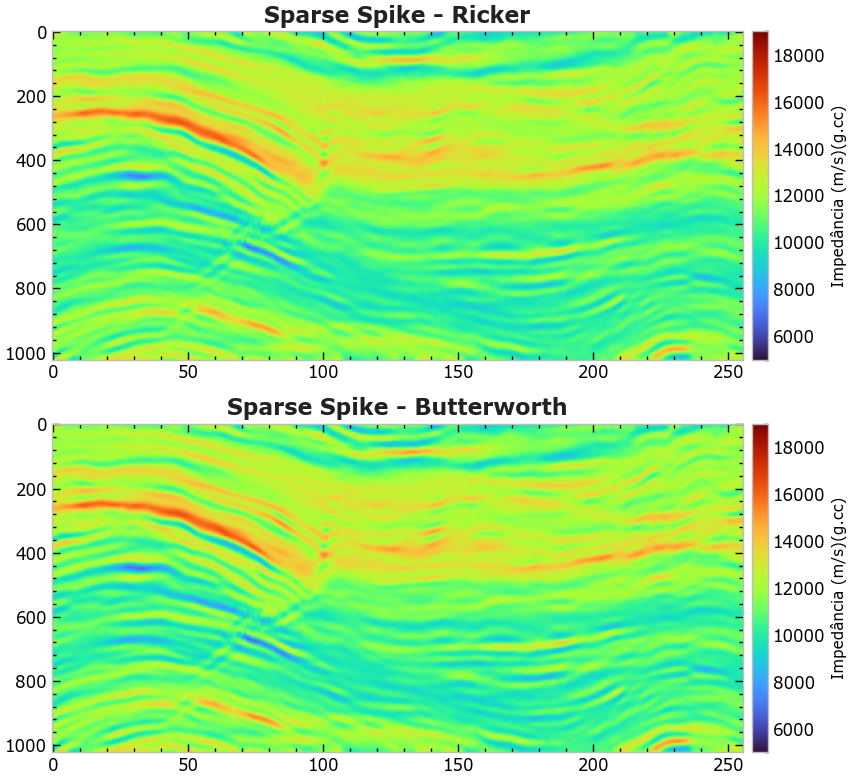

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(9, 8))

SECTION = 128

c = axs[0].imshow(
    sparse_spike_inv_ricker[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[0], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[0].set_title(
    "Sparse Spike - Ricker",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[0].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[0].get_yticks()]
)  # Altera os rótulos do eixo y
axs[0].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[0].grid(False)

c = axs[1].imshow(
    sparse_spike_inv_butter[:, SECTION, :].T,
    cmap="turbo",
    aspect="auto",
    vmin=VMIN,
    vmax=VMAX,
)
cbar = fig.colorbar(c, ax=axs[1], pad=0.01)
cbar.set_label("Impedância (m/s)(g.cc)", size=11)
cbar.ax.tick_params(labelsize=LABEL_SIZE)
axs[1].set_title(
    "Sparse Spike - Butterworth",
    fontsize=FONT_SIZE,
    fontweight="bold",
    color=TEXT_COLOR,
)
axs[1].set_yticklabels(
    [str(int(tick) * 4) for tick in axs[1].get_yticks()]
)  # Altera os rótulos do eixo y
axs[1].tick_params(axis="both", labelsize=LABEL_SIZE)
axs[1].grid(False)

plt.tight_layout()
#plt.savefig("Figures/views/ss_ricker_butter.png", dpi=500, bbox_inches="tight")
plt.show()